In [5]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.stats import multivariate_normal
from scipy.stats import bernoulli

# _Notebook des codes utilisés pour les illustrations_

Dans ce notebook se trouve les codes utilisés pour générer les illustrations d'exemple du comportement des différentes de Metropolis Hastings.

Représentons la densité cible qui va nous servir dans les illustrations :

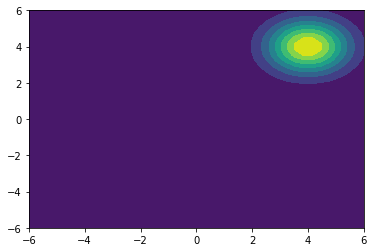

In [6]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

d = 2

# Our 2-dimensional distribution will be over variables X and Y
N = 40
X = np.linspace(-6, 6, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([4, 4])
Sigma = np.array([[ 1. , 0], [0,  1.]])
mu2 = np.array([-4,-4])

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos."""

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)

plt.show()

## 1) Metropolis Hastings classique

Dans cette partie, nous allons illustrer le comportement de la méthode classique dans différentes situations.

In [3]:
# Standard simple Metropolis Hastings with a proposition which follows a normal distribution of covariance matrix 
# which is the identity

def MH(f,Q,q,n,d,init):
    # The initial point is drawn from a normal distribution of mean given by init
    X0 = np.random.multivariate_normal([init]*d,np.diag(np.full(d,1))) #The initial density is standard normal distribution
    X = [X0]
    for i in range(n):
        Y = Q(X[i])
        a = f(Y)*q(Y, X[i])
        b = f(X[i])*q(X[i],Y)
        if b!=0:
            rho = min(1,a/b)
        else:
            rho = 1
        W = bernoulli.rvs(rho, size=1)
        if W == 1:
            X.append(Y)
        else :
            X.append(X[i])
    return X


def Q(x):
    return np.random.multivariate_normal(x,np.diag(np.full(d,1)))

def q(x,xi):
    return multivariate_normal(mean=xi, cov=np.diag(np.full(d,1))).pdf(x)


Nous allons dans un premier temps regarder le comportement de la méthode pour une densité cible qui est une gaussienne de moyenne (4,4) de covariance l'identité. Nous nous plaçons dans un premier temps dans un cadre de "cold start" où la distribution initiale est une distribution normale centrée réduite, puis dans un second temps dans le cas d'un bon départ (distribution normale de moyenne (4,4)), et dans les deux cas, nous tirons 5000 échantillons. L'erreur moyenne quadratique est donnée par :
$$MSE = ||\mu - \hat{\mu}||_2$$ où $\mu$ est la vraie moyenne et $\hat{\mu}$ est la moyenne estimée à partir des échantillons tirés.

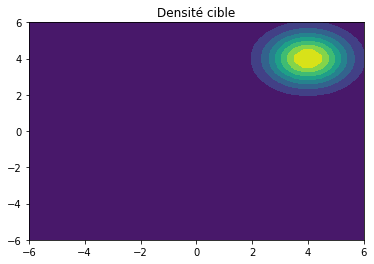

0.006291492336784195


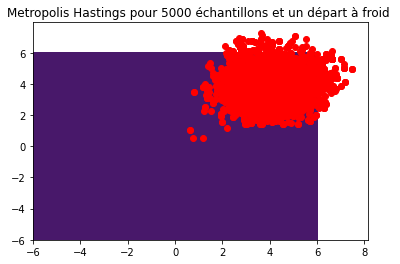

0.0004214140986439008


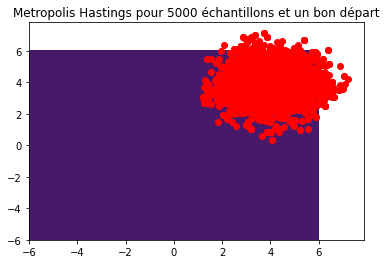

In [7]:
#Graphes avec particules tirées pour gaussienne simple

Z = multivariate_gaussian(pos, mu, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X, mean1=mu):
    return multivariate_normal(mean=mean1, cov=Sigma).pdf(X)

samples = MH(f,Q,q,5000,2,0)
MSE = np.sum((mu-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et un départ à froid ")
plt.show()


samples = MH(f,Q,q,5000,2,4)
MSE = np.sum((mu-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et un bon départ")
plt.show()

En ce qui concerne une densité cible qui est une double gaussienne, nous avons cherché à observer le comportement de la méthode en fonction de l'écartement des moyennes et de la qualité du départ, toujours pour 5000 échantillons.

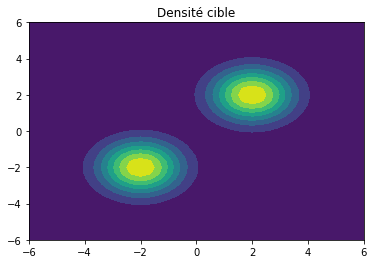

0.29945104732271943


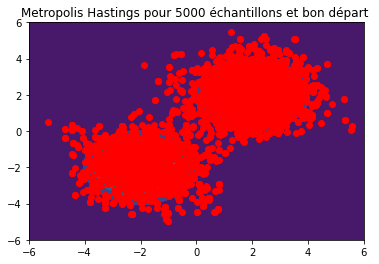

0.10180820921343317


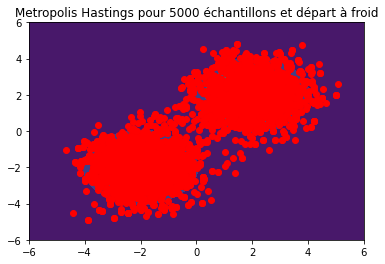

In [7]:
# Graphes avec particules tirées pour double gaussienne 

mu = np.array([2, 2])
mu2 = - mu

Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)


samples = MH(f,Q,q,5000,2,0)
MSE = np.sum(((mu+mu2)-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et bon départ ")
plt.show()

samples = MH(f,Q,q,5000,2,4)
MSE = np.sum(((mu+mu2)-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et départ à froid")
plt.show()

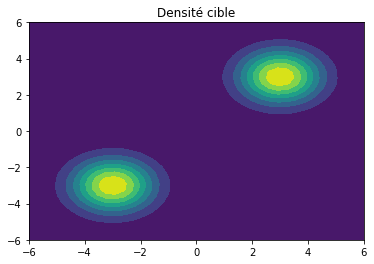

0.01462503901670376


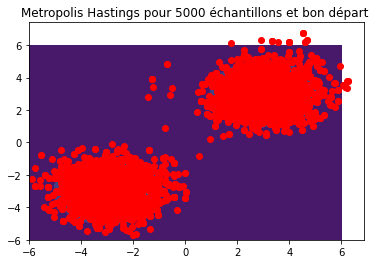

12.51209779029032


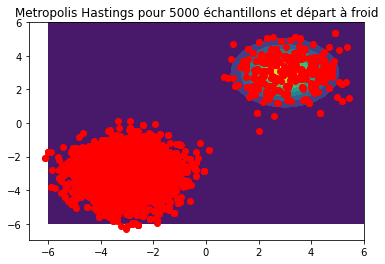

In [10]:
# Graphes avec particules tirées pour double gaussienne

mu = np.array([3, 3])
mu2 = - mu

Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)


samples = MH(f,Q,q,5000,2,0)
MSE = np.sum(((mu+mu2)-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et bon départ ")
plt.show()

samples = MH(f,Q,q,5000,2,4)
MSE = np.sum(((mu+mu2)-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et départ à froid")
plt.show()

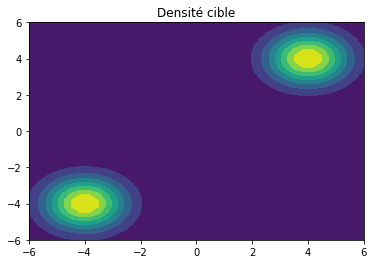

32.107219975738474


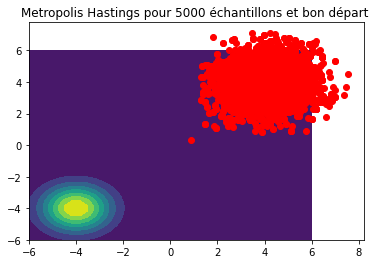

32.95900128649289


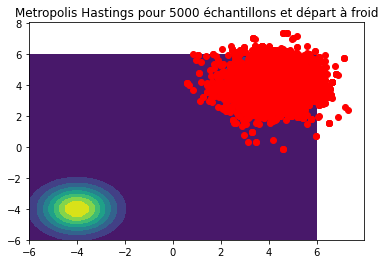

In [9]:
# Graphes avec particules tirées pour double gaussienne

mu = np.array([4, 4])
mu2 = - mu

Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)


samples = MH(f,Q,q,5000,2,0)
MSE = np.sum(((mu+mu2)-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et bon départ ")
plt.show()

samples = MH(f,Q,q,5000,2,4)
MSE = np.sum(((mu+mu2)-np.array(samples).mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons et départ à froid")
plt.show()

Afin de pouvoir avoir une idée plus "générale" du comportement de la méthode, nous avons calculé l'erreur quadratique moyenne sur 20 fois à chaque fois pour un tirage de n points (pour n entre 1000 et 10 000) pour la dernière situation, qui va être celle de référence pour la comparaison des méthodes dans la suite. 

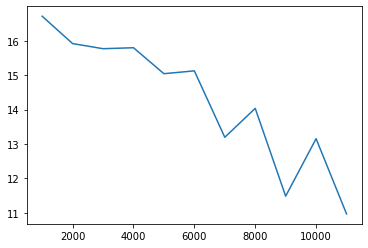

In [11]:
# MSE

points = [1000+k*1000 for k in range(11)]
mean_mse=[]
for n in points:
    tpm = []
    for j in range(20):
        mse = np.sum(((mu+mu2)-np.array(MH(f,Q,q,n,2,0)).mean(axis=0))**2)
        tpm.append(mse)
    mean_mse.append(np.mean(tpm))
    
plt.plot(points,mean_mse)
plt.show()

## 2) Metropolis Hastings Adaptatif

Nous implémentons la méthode de Metropolis Hastings adaptative tel que présentée par Haario et al. $t_0$ définit une période initiale où la covariance initiale est fixée et choisie arbitrairement ; plus $t_0$ est grand, plus l'effet adaptatif sera retardé, et d'une certaine façon cette période initiale reflète notre confiance dans le choix de la covariance initiale. Le choix de la covariance initiale est une matrice identité multipliée par un scalaire $h$ que l'on choisit.

In [12]:
# MHA

def MHA(f,n,d,epsilon,t0,init,h):
    X0 = np.random.multivariate_normal([init]*d,h*np.diag(np.full(d,1))) #The initial density is standard normal distribution
    X = X0
    for i in range(n):
        if i==0:
            Y = np.random.multivariate_normal(X0,h*np.diag(np.full(d,1)))
            a = f(Y)
            b = f(X0)
        elif (1<=i<=t0):
            Y = np.random.multivariate_normal(X[i],h*np.diag(np.full(d,1)))
            a = f(Y)
            b = f(X[i])
        else:
            Y = np.random.multivariate_normal(X[i],((2.4**2)/d)*(np.cov(X,rowvar=False)+epsilon*np.identity(d)))
            a = f(Y)
            b = f(X[i])
        if b!=0:
            rho = min(1,a/b)
        else:
            rho = 1
        W = bernoulli.rvs(rho, size=1)
        if W == 1:
            X = np.vstack((X,Y))
        else :
            if i ==0:
                X = np.vstack((X,X0))
            else:
                X = np.vstack((X,X[i]))
    return X

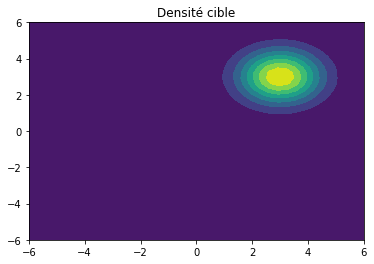

0.002059776476682255


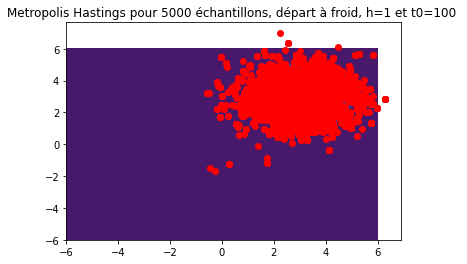

0.0066871795753353155


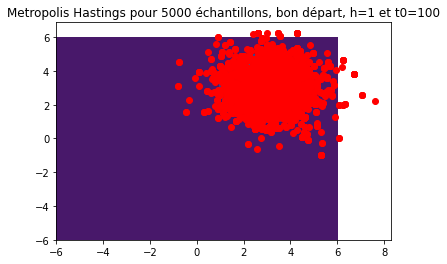

In [13]:
#Graphes avec particules tirées pour gaussienne simple

Z = multivariate_gaussian(pos, mu, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X, mean1=mu):
    return multivariate_normal(mean=mean1, cov=Sigma).pdf(X)

samples = MHA(f,5000,2,0.5,100,0,1)
MSE = np.sum((mu-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, départ à froid, h=1 et t0=100 ")
plt.show()


samples = MHA(f,5000,2,0.5,100,4,1)
MSE = np.sum((mu-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, bon départ, h=1 et t0=100")
plt.show()

En ce qui concerne la double gaussienne de moyennes (4,4) et (-4,-4) :

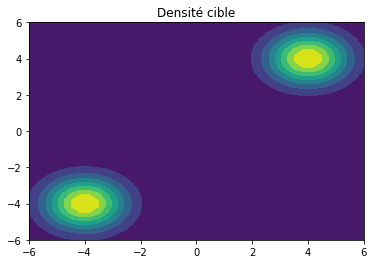

0.37244432376010145


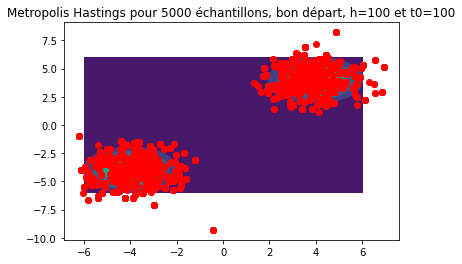

0.02300412871649767


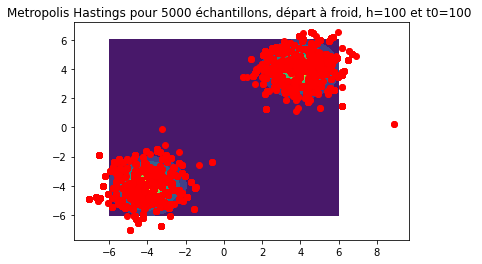

In [32]:
# Graphes avec particules tirées pour double gaussienne

Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)


samples = MHA(f,5000,2,0.5,100,0,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, bon départ, h=100 et t0=100")
plt.show()

samples = MHA(f,5000,2,0.5,100,4,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, départ à froid, h=100 et t0=100 ")
plt.show()

Si les deux moyennes sont encore plus éloignées, nous pouvons voir que la méthode s'adapte encore mais un bon résultat est moins fréquent selon l'exécution, mais il est également possible d'augmenter la durée de la période initiale (on est moins confiant vis-à-vis de la covariance initiale) :

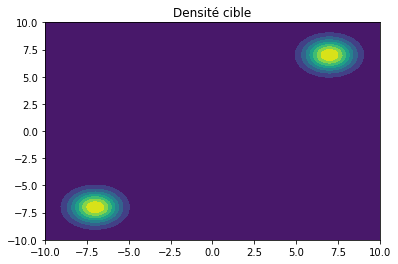

96.78882793535342


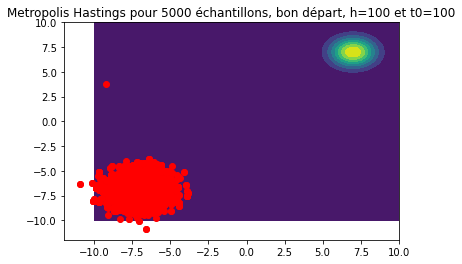

0.025798979525233422


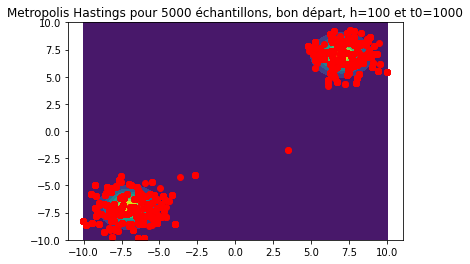

97.88052440766548


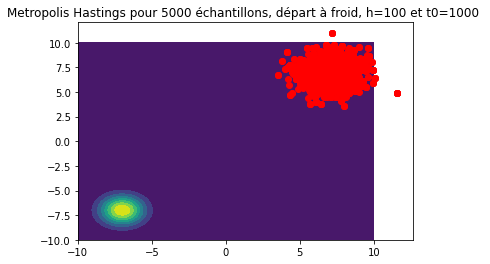

In [33]:
N = 100
X = np.linspace(-10, 10, N)
Y = np.linspace(-10, 10, N)
X, Y = np.meshgrid(X, Y)


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu = np.array([7, 7])
mu2 = - mu
Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)

samples = MHA(f,5000,2,0.5,100,0,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, bon départ, h=100 et t0=100")
plt.show()

samples = MHA(f,5000,2,0.5,1000,0,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, bon départ, h=100 et t0=1000")
plt.show()

samples = MHA(f,5000,2,0.5,1000,4,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings pour 5000 échantillons, départ à froid, h=100 et t0=1000 ")
plt.show()

In [44]:
# MSE avec good start

mu = np.array([4, 4])
mu2 = - mu

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)

points = [1000+k*1000 for k in range(10)]
mean_mse_MHA=[]
for n in points:
    tpm = []
    for j in range(20):
        mse = np.sum(((mu+mu2)-MHA(f,n,2,0.5,100,0,100).mean(axis=0))**2)
        tpm.append(mse)
    mean_mse_MHA.append(np.mean(tpm))


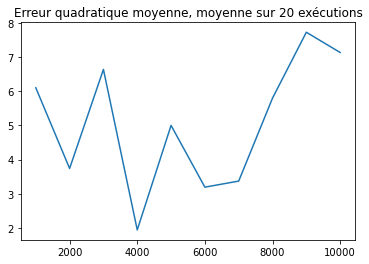

In [45]:
plt.plot(points,mean_mse_MHA)
plt.title("Erreur quadratique moyenne, moyenne sur 20 exécutions")
plt.show()

## 3) Mixture de noyau

### Principe illustré

In [1]:
from scipy.stats import uniform
import numpy.random as rd

def q_uni_ind(x,xi):
    for i in range(len(x)):
        if(abs(x[i])>1/2):
            return 0
    return 1

def Q_uni_ind(x):
    return np.random.uniform(low=-1/2,high=1/2,size=len(x))

def q_gauss_rw(x,xi):
    return multivariate_normal(mean=xi, cov=np.diag(np.full(d,1))).pdf(x)

def Q_gauss_rw(x):
    return np.random.multivariate_normal(x,np.diag(np.full(d,1)))


def Q_mixture(x):
    a = rd.binomial(1, 0.5, 1)
    return Q_uni_ind(x)*a+Q_gauss_rw(x)*(1-a)

def q_mixture(x,xi):
    return q_uni_ind(x,xi)*0.5+q_gauss_rw(x,xi)*0.5



def q_uni_rw(x,xi):
    for i in range(len(x)):
        if(abs(x[i]-xi[i])>1/2):
            return 0
    return 1

def Q_uni_rw(x):
    return np.random.uniform(low=x-1/2,high=x+1/2,size=len(x))

def q_gauss_ind(x,xi):
    return multivariate_normal(mean=x, cov=np.diag(np.full(d,1))).pdf(0)

def Q_gauss_ind(x):
    return np.random.multivariate_normal(np.zeros(len(x)),np.diag(np.full(d,1)))


def Q_mixture_2(x):
    a = rd.binomial(1, 0.5, 1)
    return Q_uni_rw(x)*a+Q_gauss_ind(x)*(1-a)

def q_mixture_2(x,xi):
    return q_uni_rw(x,xi)*0.5+q_gauss_ind(x,xi)*0.5

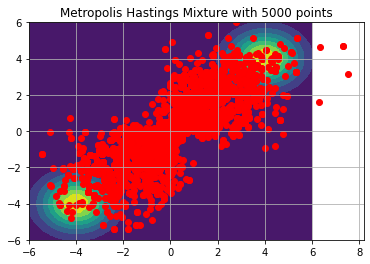

In [11]:
mu = np.array([4, 4])
mu2 = - mu
Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)
samples = MH(f,Q_mixture, q_mixture,5000,2,0)

plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')


plt.title('Metropolis Hastings Mixture with 5000 points')
plt.grid()
plt.show()

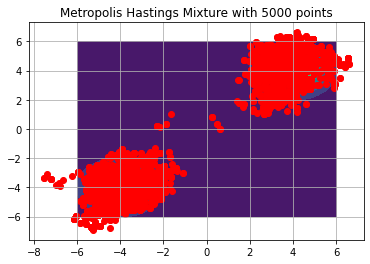

In [12]:
samples = MH(f,Q_mixture_2, q_mixture_2,5000,2,0)

plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')


plt.title('Metropolis Hastings Mixture with 5000 points')
plt.grid()
plt.show()

## 4) Metropolis Hastings avec noyau

In [23]:
def MHK(f,h,n,d,init):
    X0 = np.random.multivariate_normal([init]*d,np.diag(np.full(d,1))) #The initial density is standard normal distribution
    X = X0  
    for i in range(n):
        if i==0:
            Y = np.random.multivariate_normal(X,(h**2)*np.identity(d))
            a = f(Y)
            b = f(X)
        else:
            j = list(np.random.multinomial(1, [1/len(X)]*len(X), size=1)[0]).index(1)
            Y = np.random.multivariate_normal(X[j],(h**2)*np.identity(d))
            a = f(Y)
            b = f(X[i])
        
        if b!=0:
            rho = min(1,a/b)
        else:
            rho = 1
        W = bernoulli.rvs(rho, size=1)
        if W == 1:
            X = np.vstack((X,Y))
        else :
            if i ==0:
                X = np.vstack((X,X0))
            else:
                X = np.vstack((X,X[i]))
    return X
    

Testons la méthode avec noyau pour la gaussienne simple de moyenne (4,4) :

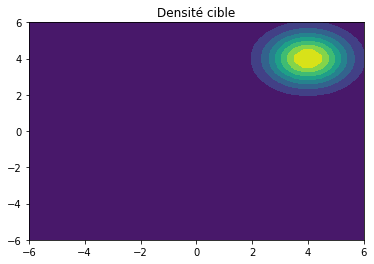

0.021590304178713028


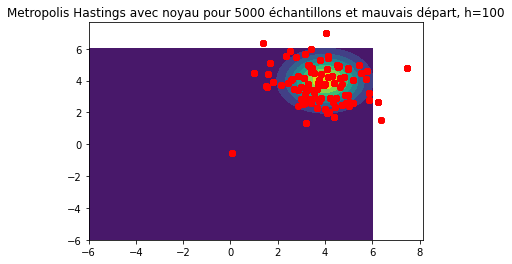

0.04004842735166572


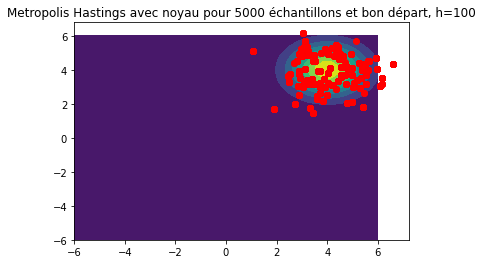

In [34]:
#Graphes avec particules tirées pour gaussienne simple

N = 40
X = np.linspace(-6, 6, N)
Y = np.linspace(-6, 6, N)
X, Y = np.meshgrid(X, Y)


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu = np.array([4, 4])
mu2 = - mu
Z = multivariate_gaussian(pos, mu, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()


def f(X, mean1=mu):
    return multivariate_normal(mean=mean1, cov=Sigma).pdf(X)

samples = MHK(f,10,5000,2,0)
MSE = np.sum((mu-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings avec noyau pour 5000 échantillons et mauvais départ, h=10") 
plt.show()


samples = MHK(f,10,5000,2,4)
MSE = np.sum((mu-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings avec noyau pour 5000 échantillons et bon départ, h=10")  
plt.show()

En ce qui concerne la double gaussienne : 

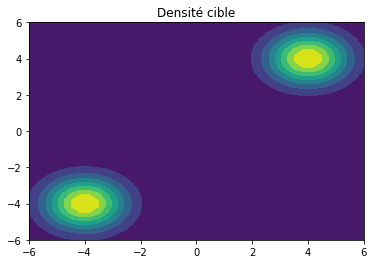

0.5521879292049323


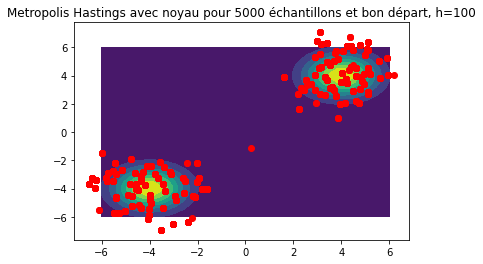

0.32085821062534203


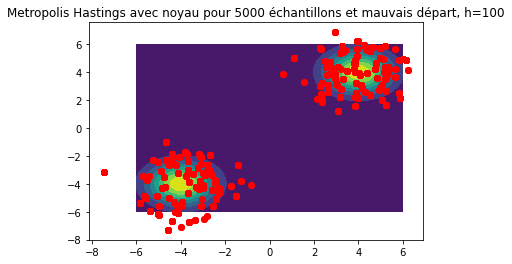

In [35]:
# Graphes avec particules tirées pour double gaussienne

Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)


samples = MHK(f,10,5000,2,0)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings avec noyau pour 5000 échantillons et bon départ, h=100")
plt.show()

samples = MHK(f,10,5000,2,4)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings avec noyau pour 5000 échantillons et mauvais départ, h=100")
plt.show()

In [46]:
# MSE avec good start

points = [1000+k*1000 for k in range(10)]
mean_mse_MHK=[]
for n in points:
    tpm = []
    for j in range(20):
        mse = np.sum(((mu+mu2)-MHK(f,10,n,2,0).mean(axis=0))**2)
        tpm.append(mse)
    mean_mse_MHK.append(np.mean(tpm))

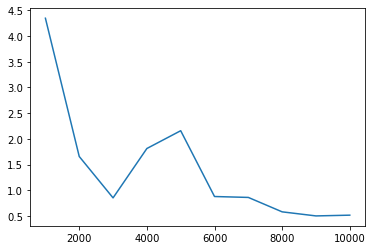

In [47]:
plt.plot(points, mean_mse_MHK)

## 5) Metropolis Hastings avec noyau adaptatif

De même que pour Metropolis Hastings adaptatif, on définit un temps initial $t_0$ durant lequel on se contente d'une covariance initiale fixée arbitrairement. Ici aussi, il s'agira d'une matrice identité multipliée par un scalaire $h$.

In [29]:
def MHKA(f,n,d,epsilon,t0,init,h):
    X0 = np.random.multivariate_normal([init]*d,h*np.diag(np.full(d,1))) #The initial density is standard normal distribution
    X = X0  
    for i in range(n):
        if i<t0:
            cov = h*np.diag(np.full(d,1))
        else:
            cov = ((2.4**2)/d)*(np.cov(X,rowvar=False)+epsilon*np.identity(d))
        if i==0:
            Y = np.random.multivariate_normal(X,h*np.diag(np.full(d,1)))
            a = f(Y)
            b = f(X)
        else:
            j = list(np.random.multinomial(1, [1/len(X)]*len(X), size=1)[0]).index(1)
            Y = np.random.multivariate_normal(X[j],cov)
            a = f(Y)
            b = f(X[i])
        
        if b!=0:
            rho = min(1,a/b)
        else:
            rho = 1
        W = bernoulli.rvs(rho, size=1)
        if W == 1:
            X = np.vstack((X,Y))
        else:
            if i ==0:
                X = np.vstack((X,X0))
            else:
                X = np.vstack((X,X[i]))
    return X
        

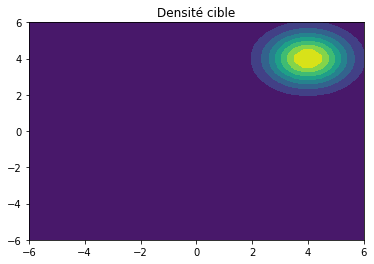

0.004936360147651846


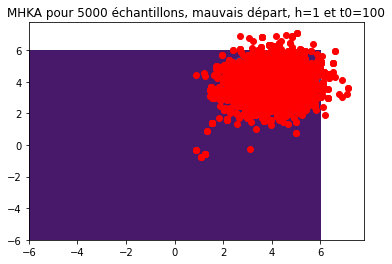

0.0038206605699491365


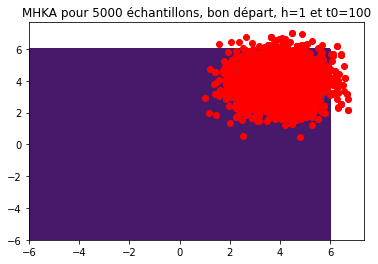

In [36]:
#Graphes avec particules tirées pour gaussienne simple

Z = multivariate_gaussian(pos, mu, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X, mean1=mu):
    return multivariate_normal(mean=mean1, cov=Sigma).pdf(X)

samples = MHKA(f,5000,2,0.5,100,0,1)
MSE = np.sum((mu-samples.mean(axis=0))**2)
print(MSE)
Z = multivariate_gaussian(pos, mu, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("MHKA pour 5000 échantillons, mauvais départ, h=1 et t0=100")
plt.show()


samples = MHKA(f,5000,2,0.5,100,4,1)
MSE = np.sum((mu-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("MHKA pour 5000 échantillons, bon départ, h=1 et t0=100")
plt.show()

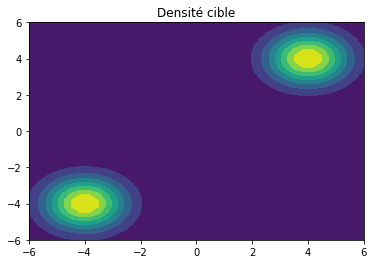

0.31126224758812837


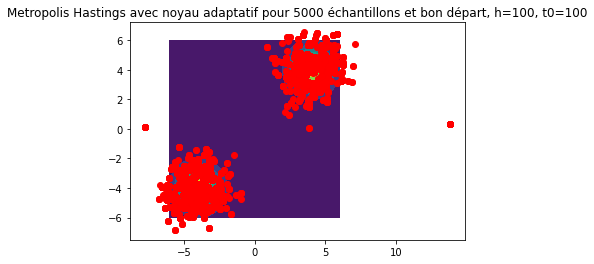

0.021788776492124913


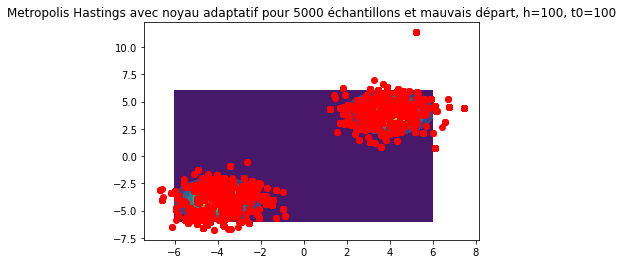

In [43]:
# Graphes avec particules tirées pour double gaussienne

Z = multivariate_gaussian(pos, mu, Sigma) + multivariate_gaussian(pos, mu2, Sigma)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.title("Densité cible")
plt.show()

def f(X):
    return multivariate_normal(mean=mu, cov=Sigma).pdf(X)+multivariate_normal(mean=mu2, cov=Sigma).pdf(X)


samples = MHKA(f,5000,2,0.5,100,0,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings avec noyau adaptatif pour 5000 échantillons et bon départ, h=100, t0=100")
plt.show()

samples = MHKA(f,5000,2,0.5,100,4,100)
MSE = np.sum(((mu+mu2)-samples.mean(axis=0))**2)
print(MSE)
plt.contourf(X, Y, Z, cmap=cm.viridis)
plt.scatter([samples[k][0] for k in range(len(samples))],[samples[k][1] for k in range(len(samples))], c='red')
plt.title("Metropolis Hastings avec noyau adaptatif pour 5000 échantillons et mauvais départ, h=100, t0=100")
plt.show()

In [50]:
# MSE avec good start

points = [1000+k*1000 for k in range(10)]
mean_mse_MHKA=[]
for n in points:
    tpm = []
    for j in range(20):
        mse = np.sum(((mu+mu2)-MHKA(f,n,2,0.5,100,0,100).mean(axis=0))**2)
        tpm.append(mse)
    mean_mse_MHKA.append(np.mean(tpm))

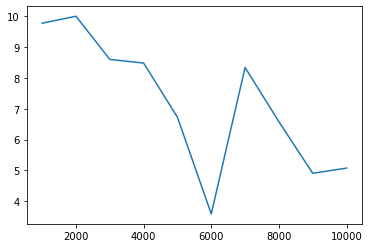

In [51]:
plt.plot(points, mean_mse_MHKA)

Empiriquement, il semblerait qu'une période initiale correcte soit le cinquième du nombre de tirages à la fin :

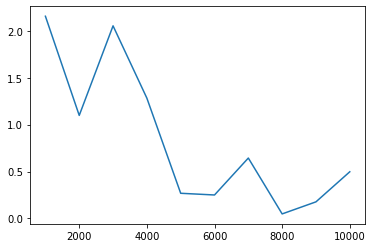

In [107]:
# Pour la méthode à noyau adaptatif

mean_mse_MHKA2 = []
for n in points:
    tpm = []
    for j in range(20):
        mse = np.sum(((mu+mu2)-MHKA(f,n,2,0.5,n//5,0,100).mean(axis=0))**2)
        tpm.append(mse)
    mean_mse_MHKA2.append(np.mean(tpm))


In [55]:
# Pour MHA avec une periode initiale du nombre final de points divisé par 5

mean_mse_MHA2=[]
for n in points:
    tpm = []
    for j in range(20):
        mse = np.sum(((mu+mu2)-MHA(f,n,2,0.5,n//5,0,100).mean(axis=0))**2)
        tpm.append(mse)
    mean_mse_MHA2.append(np.mean(tpm))


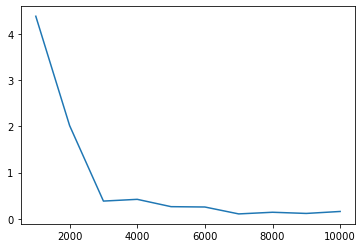

In [56]:
plt.plot(points, mean_mse_MHA2)

### Comparaison des méthodes

Les comparaisons ont été réalisées pour la double gaussienne de moyenne (4,4) et (-4,-4) avec une distribution initiale selon une loi normale centrée réduite. Pour les méthodes MHA et MHKA, on a pris une période initiale de 100 tirages, h=100 et epsilon =0.5.

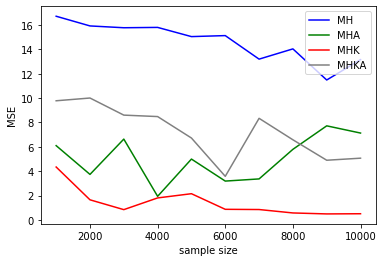

In [54]:
plt.plot(points, mean_mse[:10], c='blue')
plt.plot(points, mean_mse_MHA, c='green')
plt.plot(points, mean_mse_MHK, c='red')
plt.plot(points, mean_mse_MHKA, c='grey')
plt.legend(["MH", "MHA", 'MHK', 'MHKA'], loc='best')
plt.xlabel("sample size")
plt.ylabel("MSE")
plt.show()